In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==2.2.0
!pip install keras==2.2.0

In [1]:
import pandas as pd
import numpy as np
from scipy.ndimage import zoom, rotate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
from glob import glob
import os

In [3]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import Sequence
import keras.backend as K

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [7]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
set_session(tf.compat.v1.Session(config=config))

In [10]:
n_classes = 1
chanels = 1
batch_size = 110
vol_size = np.array([24, 24, 24])

path_base = '/content/drive/MyDrive/LIDC/nodules/*.npz'

In [11]:
def normalize(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray = np.clip(npzarray, 0, 1)
    return npzarray

In [12]:
def get_data(path):
    file_name = os.path.basename(path)
    tag = int(file_name.split('_')[2])
    
    file = np.load(path)
    vol = file['patch']
    file.close()
    
    vol = normalize(vol)
    return vol, tag

In [25]:
class Sequence_data(Sequence):

    def __init__(self, data, batch_size):
        # recive una lista de rutas de donde están los volumenes como numpy arrays y el batch_size
        self.data = data
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def __getitem__(self, idx):
        # lista de rutas para el batch actual
        batch_x = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = []
        y = []
        
        # se cargan los volumenes y las mascaras en sus respectivos arrays
        for path in batch_x:
            data, tag = get_data(path)
            X.append(data)
            
            temp_y = [0, 0]
            temp_y[tag] = 1
            
            y.append(temp_y)
            
        X = np.array(X)
        y = np.array(y)
        
        try:
            resahped = X.reshape((*X.shape, chanels)), y #.reshape(-1, n_classes)
        except Exception as ex:
            print('ojooooooo')
            print(batch_x, ex)
        return resahped

In [26]:
ids_train = glob(path_base.format("train"))
ids_test = glob(path_base.format("test"))

In [38]:
seq_train = Sequence_data(ids_train, batch_size)
seq_test = Sequence_data(ids_test, batch_size)

In [40]:
from keras.models import Model
from keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling3D, Flatten
from keras.layers import MaxPool3D, Conv3D, Input

In [41]:
def get_model(size = (24, 24, 24)):
    
    width, height, depth = size

    inputs = Input((width, height, depth, 1))

    x = Conv3D(filters=128, kernel_size=3, activation="relu")(inputs)
    x = BatchNormalization()(x)
    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPool3D(pool_size=2)(x)
    
    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPool3D(pool_size=2)(x)
    
    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv3D(filters=128, kernel_size=2, activation="relu")(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    outputs = Dense(units=2, activation="softmax")(x)

    # Define the model.
    model = Model(inputs, outputs, name="3dcnn")
    return model

In [42]:
model = get_model()

AttributeError: ignored

In [ ]:
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 126, 126, 62, 128) 3584      
_________________________________________________________________
batch_normalization_9 (Batch (None, 126, 126, 62, 128) 512       
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 124, 124, 60, 128) 442496    
_________________________________________________________________
batch_normalization_10 (Batc (None, 124, 124, 60, 128) 512       
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 122, 122, 58, 128) 442496    
_________________________________________________________________
batch_normalization_11 (Batc (None, 122, 122, 58, 128) 512   

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
ES = EarlyStopping(patience=20, min_delta=0.00001, restore_best_weights=True)
MCP = ModelCheckpoint(filepath="./weights_cancer/weights_2.{epoch:02d}.hdf5", save_best_only=True, save_weights_only=False)
callbacks = [ES, MCP]

In [ ]:
history = model.fit_generator(seq_train, validation_data=seq_test , steps_per_epoch=int(len(ids_train)/batch_size), epochs=2000, callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2000
19/19 [==============================] - 6s 340ms/step - loss: 6.5485 - acc: 0.5696 - val_loss: 6.4740 - val_acc: 0.5967
Epoch 2/2000
19/19 [==============================] - 3s 174ms/step - loss: 6.8888 - acc: 0.5708 - val_loss: 7.5273 - val_acc: 0.5316
Epoch 3/2000
19/19 [==============================] - 3s 181ms/step - loss: 6.8920 - acc: 0.5708 - val_loss: 7.0391 - val_acc: 0.5613
Epoch 4/2000
19/19 [==============================] - 4s 185ms/step - loss: 6.5554 - acc: 0.5923 - val_loss: 6.7109 - val_acc: 0.5836
Epoch 5/2000
19/19 [==============================] - 3s 169ms/step - loss: 6.8222 - acc: 0.5759 - val_loss: 6.8008 - val_acc: 0.5781
Epoch 6/2000
19/19 [==============================] - 3s 171ms/step - loss: 6.8019 - acc: 0.5779 - val_loss: 7.0404 - val_acc: 0.5632
Epoch 7/2000
19/19 [==============================] - 3s 165ms/step - loss: 6.8979 - acc: 0.5718 - val_loss: 7.1259 - val_acc: 0.5576
Epoch 8/2000
1

In [ ]:
import matplotlib.pyplot as plt

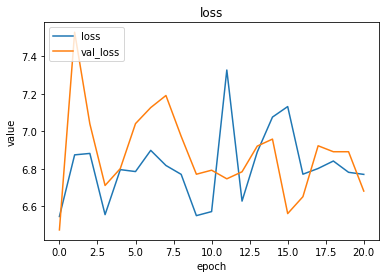

In [ ]:
# Plot history: MAE
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('loss')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.show()

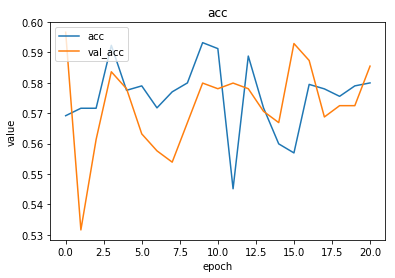

In [ ]:
# Plot history: MAE
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.title('acc')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
pred = model.predict_generator(seq_test)

In [ ]:
tags = [int("_1_" in path) for path in ids_test]

In [ ]:
print(classification_report(tags, (pred.argmax(-1) > 0.5).astype(np.int).flatten()))

             precision    recall  f1-score   support

          0       0.59      0.14      0.23       227
          1       0.60      0.93      0.73       311

avg / total       0.60      0.60      0.52       538



In [ ]:
print(accuracy_score(tags, (pred.argmax(-1) > 0.5).astype(np.int).flatten()))

0.5966542750929368


In [ ]:
ids_val = glob('./nodules_augmented/test/o_*.npz')
seq_val = Sequence_data(ids_val, batch_size)

In [ ]:
pred_val = model.predict_generator(seq_val)

In [ ]:
tags_val = [int("_1_" in path) for path in ids_val]

In [ ]:
print(classification_report(tags_val, (pred_val.argmax(-1) > 0.5).astype(np.int).flatten()))

             precision    recall  f1-score   support

          0       0.59      0.14      0.23       227
          1       0.60      0.93      0.73       311

avg / total       0.60      0.60      0.52       538

